* Importação das bibliotecas

In [ ]:
import os
from scipy.ndimage import rotate, zoom
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import tensorflow as tf
import time
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from IPython.display import display, Markdown as md
from collections import defaultdict
from google.colab import drive
from tensorflow.keras import layers, models, utils, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2

## Caminho do dataset
    

* Adicionei o dataset no google drive para poder facilitar o gerenciamento e manuseio das imagens. O dataset é originado do kaggle [Retina Blood Vessel](https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel).

In [ ]:
# Vai montar um Google Drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/dataset_retina'
dataset_path = Path(path)
# Definição dos caminhos das pastas de treino e teste dentro do dataset
pasta_treinamento  = os.path.join(path, "Data", "train")  # Caminho para as imagens de treino
pasta_teste  = os.path.join(path, "Data", "test")  # Caminho para as imagens de teste

Mounted at /content/drive


## EXPLORAÇÃO INICIAL DO DATASET

*   Função para coletar infos iniciais (quantas imagens, tamanho, pixels, nome da pasta, etc)





In [ ]:
imagens_info = []
for pasta_raiz, subpastas, arquivos in os.walk(path): #percorrendo diretorios e subdiretorios dentro do caminho em path
  for arquivo in arquivos: #percorre a lista de arquivos dentro da pasta atual
    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')): #se os arquivos tiverem essas extensões
      caminho_completo = os.path.join(pasta_raiz, arquivo) # cria o caminho absoluto do arquivo, unindo a pasta onde ele está com seu nome.
      categoria = os.path.basename(pasta_raiz) #retorna apenas o nome da última pasta no caminho. (ex: "C:/Users/Hanna/Imagens/Dataset/Gatos")
      #ele vai me retornar GATOS
      with Image.open(caminho_completo) as img:
                largura, altura = img.size  # Dimensões
                num_pixels = largura * altura  # Total de pixels
                modo = img.mode  # Modo da imagem (RGB, Grayscale etc.)
      imagens_info.append({
          'arquivo' : arquivo, #nome do arquivo da imagem
          'caminho' : caminho_completo, #caminho do arquivo
          'categoria' : categoria, #nome da pasta onde está a imagem
          'largura': largura, #adicionei para printar as dimensões depois
          'altura': altura, #adicionei para printar as dimensões depois
          'num_pixels': num_pixels, #adicionei para printar as dimensões depois
          'modo' : modo #modo L indica que a imagem tem 8bits por pixel, 256 níves de cinza (variando de 0 preto a 255 branco)
          }) #dicionario criado com tres infos: nomedoarquivo / caminho do arquivo / e qual categoria da imagem (mask)

df_imagens = pd.DataFrame(imagens_info) #converte a lista de dicionários em um dataframe do pandas

print(f"Total de imagens: {len(df_imagens)}") #total de imagens = 200

Total de imagens: 200



*   Conferir os formatos das imagens

In [ ]:
# Verificação se todas as imagens estão no mesmo formato
# Lista para armazenar os formatos das imagens
formatos_imagens  = set()

# Percorrer todos os arquivos do diretório

for file in dataset_path.rglob("*"):
    if file.is_file():
        try:
            with Image.open(file) as img:
                formatos_imagens .add(img.format)
        except Exception as e:
            print(f"Erro ao processar {file}: {e}")

# Exibe os formatos encontrados

print("Formatos de imagem encontrados:", formatos_imagens )

# Verifica se todas as imagens têm o mesmo formato

if len(formatos_imagens ) == 1:
    print(f"Todas as imagens estão no formato {list(formatos_imagens )[0]}.")
else:
    print("As imagens possuem formatos diferentes.")

Formatos de imagem encontrados: {'PNG'}
Todas as imagens estão no formato PNG.



*   Conferindo se todas as imagens tem o mesmo tamanho


In [ ]:
if df_imagens[['largura', 'altura']].nunique().sum() == 2: #nunique() conta quantos valores diferentes existem nas colunas largura e altura
    print("Todas as imagens têm o mesmo tamanho.")
else:
    print("As imagens têm tamanhos diferentes.")

Todas as imagens têm o mesmo tamanho.


*   Conferir o modelo de cor das imagens


In [ ]:
# Agrupa as imagens por categoria (pasta) e lista os modos de cor encontrados em cada uma
modos_por_categoria = df_imagens.groupby('categoria')['modo'].unique()

# Exibe os modos de cor encontrados para cada categoria
for categoria, modos in modos_por_categoria.items():
    print(f"Na pasta '{categoria}', encontramos os modos de cor: {modos}")

# Cria um dicionário para armazenar inconsistências
# Se uma categoria tiver mais de um modo de cor, será considerada inconsistente
inconsistencias = {cat: modos for cat, modos in modos_por_categoria.items() if len(modos) > 1}

# Verifica se foram encontradas inconsistências
if inconsistencias:
    print("\nAtenção! Algumas categorias possuem imagens com diferentes modos de cor:")
    for cat, modos in inconsistencias.items():
        print(f"- {cat}: {modos}")  # Exibe a categoria e os modos de cor encontrados nela
else:
    print("\nTodas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.")


Na pasta 'image', encontramos os modos de cor: ['RGB']
Na pasta 'mask', encontramos os modos de cor: ['L']

Todas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.


*  Tabela com infos gerais das imagens (categoria, largura, altura)

In [ ]:
def sumario_coluna(df):

    dados_resumo = []

    for nome_coluna in df.columns:
        tipo_coluna = df[nome_coluna].dtype
        valores_distintos = df[nome_coluna].nunique()

        contagem_distintos = None
        if valores_distintos <= 10:
            contagem_distintos = df[nome_coluna].value_counts().to_dict()

        dados_resumo.append([
            nome_coluna,
            str(tipo_coluna),
            valores_distintos,
            contagem_distintos
        ])

    # Markdown para exibição
    saida_markdown = "## 📊 Sumário das Colunas\n\n"
    saida_markdown += "| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |\n"
    saida_markdown += "|--------|---------------|-------------------|--------------------------|\n"

    for col in dados_resumo:
        distribuicao = col[3] if col[3] is not None else "N/A"
        saida_markdown += f"| `{col[0]}` | `{col[1]}` | {col[2]} | {distribuicao} |\n"

    display(md(saida_markdown))

# Exemplo de uso
sumario_coluna(df_imagens)

## 📊 Sumário das Colunas

| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |
|--------|---------------|-------------------|--------------------------|
| `arquivo` | `object` | 80 | N/A |
| `caminho` | `object` | 200 | N/A |
| `categoria` | `object` | 2 | {'mask': 100, 'image': 100} |
| `largura` | `int64` | 1 | {512: 200} |
| `altura` | `int64` | 1 | {512: 200} |
| `num_pixels` | `int64` | 1 | {262144: 200} |
| `modo` | `object` | 2 | {'L': 100, 'RGB': 100} |


* Visualizando algumas imagens do dataset

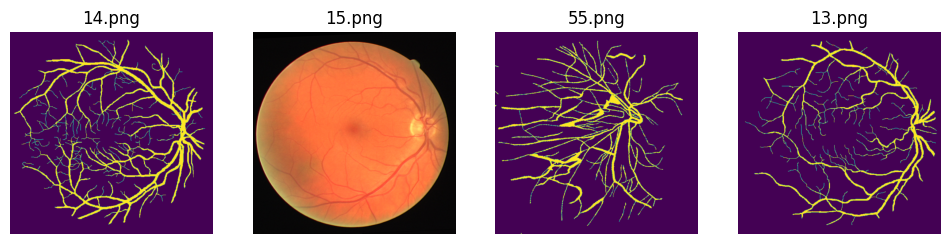

In [ ]:
amostras = df_imagens.sample(4)  # visualizando 4 imagens do dataframe

fig, axes = plt.subplots(1, 4, figsize=(12, 6)) #plotando as imagens
for ax, (_, row) in zip(axes, amostras.iterrows()):
    img = Image.open(row["caminho"])  # Abre a imagem
    ax.imshow(img)
    ax.set_title(row["arquivo"])
    ax.axis("off")  # Remove os eixos

plt.show()

Informações complementares, tamanho, pixel e dimensões da figura

In [ ]:
print(df_imagens[['largura', 'altura', 'num_pixels']].describe()) #não há variação nas imagens

       largura  altura  num_pixels
count    200.0   200.0       200.0
mean     512.0   512.0    262144.0
std        0.0     0.0         0.0
min      512.0   512.0    262144.0
25%      512.0   512.0    262144.0
50%      512.0   512.0    262144.0
75%      512.0   512.0    262144.0
max      512.0   512.0    262144.0


* Verificando se há imagens corrompidas que não podem abertas ou processadas

In [ ]:
def verificar_imagens_corrompidas(caminho_pasta):
    imagens_corrompidas = []

    for raiz, _, arquivos in os.walk(caminho_pasta):  # Percorre recursivamente o diretório do dataset
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(raiz, arquivo)
            try:
                with Image.open(caminho_arquivo) as imagem:  # Tenta abrir cada imagem
                    imagem.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as erro:  # Se ocorrer um erro, a imagem é considerada corrompida
                print(f"Imagem corrompida encontrada: {caminho_arquivo} - Erro: {erro}")
                imagens_corrompidas.append(caminho_arquivo)

    return imagens_corrompidas

# Executa a verificação e exibe o número de imagens corrompidas
imagens_corrompidas = verificar_imagens_corrompidas(path)
print(f"Número de imagens corrompidas: {len(imagens_corrompidas)}")

Número de imagens corrompidas: 0


* Distribuição das classes para identificar possíveis desequilíbrios que possam afetar a modelagem

Distribuição das classes no conjunto de treino: {'mask': 80, 'image': 80}
Distribuição das classes no conjunto de teste: {'mask': 20, 'image': 20}


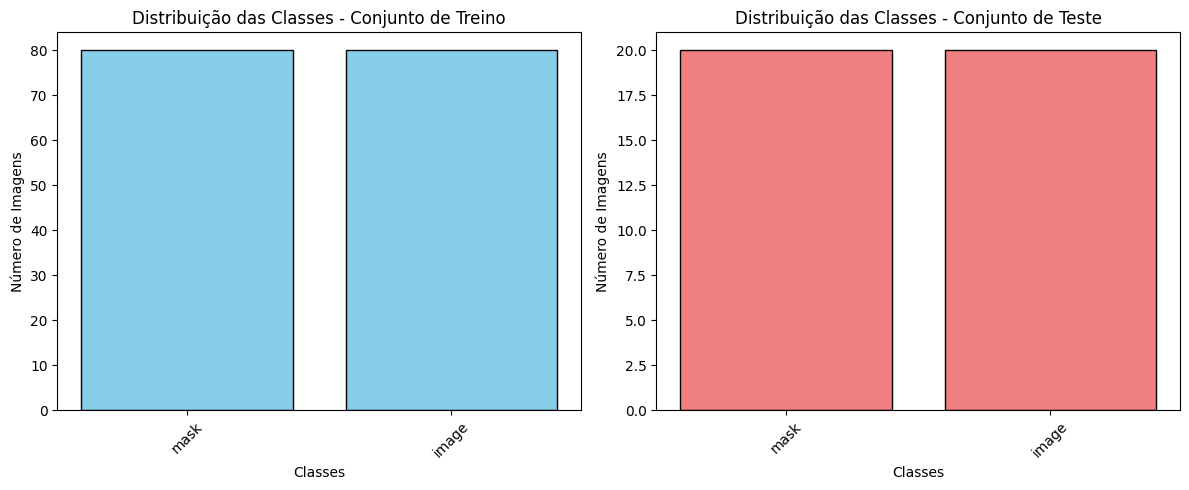

In [ ]:
# Função para contar o número de imagens por classe
def contar_imagens_por_classe(caminho_pasta):

    if not os.path.exists(caminho_pasta):  # Verifica se o diretório existe
        print(f"A pasta '{caminho_pasta}' não foi encontrada.")  # Exibe um aviso caso a pasta não exista
        return {}  # Retorna um dicionário vazio

    # Cria um dicionário onde cada chave é uma classe (nome da pasta) e o valor é a quantidade de imagens
    contagem_por_classe = {
        classe: len(os.listdir(os.path.join(caminho_pasta, classe)))
        for classe in os.listdir(caminho_pasta)
        if os.path.isdir(os.path.join(caminho_pasta, classe))  # Considera apenas diretórios
    }

    return contagem_por_classe  # Retorna o dicionário com as contagens

def plotar_distribuicao_classes(contagem_treino, contagem_teste):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Cria uma figura com 2 gráficos lado a lado

    # Gráfico para o conjunto de treino
    axes[0].bar(contagem_treino.keys(), contagem_treino.values(), color='skyblue', edgecolor='black')  # Cria gráfico de barras
    axes[0].set_title("Distribuição das Classes - Conjunto de Treino")  # Define o título do gráfico
    axes[0].set_xlabel("Classes")  # Nomeia o eixo X
    axes[0].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[0].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    # Gráfico para o conjunto de teste
    axes[1].bar(contagem_teste.keys(), contagem_teste.values(), color='lightcoral', edgecolor='black')  # Cria gráfico de barras
    axes[1].set_title("Distribuição das Classes - Conjunto de Teste")  # Define o título do gráfico
    axes[1].set_xlabel("Classes")  # Nomeia o eixo X
    axes[1].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[1].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    plt.show()  # Exibe os gráficos

def main():
    # Contagem das imagens por classe em cada conjunto (treino e teste)
    contagem_treino = contar_imagens_por_classe(pasta_treinamento)
    contagem_teste = contar_imagens_por_classe(pasta_teste)

    if not contagem_treino or not contagem_teste:  # Se não houver imagens em um dos conjuntos
        print("Não foi possível encontrar dados suficientes para análise.")  # Exibe um aviso
        return  # Encerra a execução

    # Exibir contagem das classes no terminal
    print("Distribuição das classes no conjunto de treino:", contagem_treino)
    print("Distribuição das classes no conjunto de teste:", contagem_teste)

    # Gerar os gráficos de distribuição das classes
    plotar_distribuicao_classes(contagem_treino, contagem_teste)


# Garante que o script só será executado se for chamado diretamente (evita execução acidental ao importar como módulo)
if __name__ == "__main__":
    main()

* Conferindo imagens duplicadas que possam enviesar os resultados.
  * Para detectar imagens duplicadas no dataset (mesmo que tenham nomes diferentes), podemos comparar os arquivos pelo hash (assinatura digital) de cada imagem. Isso garante que duas imagens idênticas serão detectadas mesmo que tenham nomes diferentes.

In [ ]:
# Função para calcular o hash de uma imagem
def calcular_hash(imagem_path):
    with Image.open(imagem_path) as img:  # Abre a imagem usando a biblioteca PIL (Pillow)
        img = img.convert("L")  # Converte para escala de cinza para reduzir variações de cor
        return hashlib.md5(img.tobytes()).hexdigest()  # Gera um hash MD5 com os bytes da imagem


# Função para encontrar duplicatas dentro de uma pasta
def encontrar_duplicatas(pasta):
    hashes = defaultdict(list)  # Dicionário onde a chave é o hash e o valor é uma lista de arquivos com o mesmo hash
    for arquivo in os.listdir(pasta):  # Percorre todos os arquivos da pasta
        caminho_completo = os.path.join(pasta, arquivo)  # Obtém o caminho completo do arquivo
        if arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):  # Verifica se é uma imagem
            hash_imagem = calcular_hash(caminho_completo)  # Calcula o hash da imagem
            hashes[hash_imagem].append(caminho_completo)  # Adiciona o arquivo à lista de imagens com esse hash

    # Criar um dicionário para armazenar apenas os hashes que possuem mais de uma imagem associada
    duplicatas = {}

    # Percorre todos os hashes e suas respectivas listas de arquivos
    for hash_valor, arquivos in hashes.items():
        # Se houver mais de um arquivo associado ao mesmo hash, significa que são duplicatas
        if len(arquivos) > 1:
            duplicatas[hash_valor] = arquivos

    return duplicatas  # Retorna um dicionário com os arquivos duplicados


pastas_imagem = [
    os.path.join(path, "Data", "train", "image"),  # Caminho para imagens de treino
    os.path.join(path, "Data", "test", "image")    # Caminho para imagens de teste
]
pastas_mask = [
    os.path.join(path, "Data", "train", "mask"),   # Caminho para máscaras de treino
    os.path.join(path, "Data", "test", "mask")     # Caminho para máscaras de teste
]


# Verificar duplicatas em imagens e máscaras separadamente
display(md("\n🔍 **Duplicatas em imagens:**"))  # Exibe um título formatado
for pasta in pastas_imagem:  # Percorre cada pasta de imagens
    duplicatas = encontrar_duplicatas(pasta)  # Chama a função para verificar duplicatas
    if duplicatas:  # Se encontrou duplicatas
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():  # Percorre os hashes e os arquivos duplicados
            display(md(f"  - Hash: {h}"))  # Exibe o hash da imagem duplicada
            for arq in arquivos:  # Exibe cada arquivo duplicado
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))  # Se não houver duplicatas


display(md("\n🔍 **Duplicatas em máscaras:**"))
for pasta in pastas_mask:  # Percorre cada pasta de máscaras
    duplicatas = encontrar_duplicatas(pasta)  # Chama a função para verificar duplicatas
    if duplicatas:  # Se encontrou duplicatas
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():  # Percorre os hashes e os arquivos duplicados
            print(f"  - Hash: {h}")  # Exibe o hash da imagem duplicada
            for arq in arquivos:  # Exibe cada arquivo duplicado
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))  # Se não houver duplicatas


🔍 **Duplicatas em imagens:**

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/train/image

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/test/image


🔍 **Duplicatas em máscaras:**

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/train/mask

Nenhuma duplicata encontrada em /content/drive/MyDrive/dataset_retina/Data/test/mask

## NORMALIZAÇÃO E REDIMENSIONAMENTO

Verificando caminho do dataset: /content/drive/MyDrive/dataset_retina
O caminho existe? True
Verificando pasta de treinamento: /content/drive/MyDrive/dataset_retina/Data/train
A pasta de treinamento existe? True
Dataset encontrado em: /content/drive/MyDrive/dataset_retina

Caminhos encontrados:
Imagens de treino: /content/drive/MyDrive/dataset_retina/Data/train/image (Existe: True)
Máscaras de treino: /content/drive/MyDrive/dataset_retina/Data/train/mask (Existe: True)
Imagens de teste: /content/drive/MyDrive/dataset_retina/Data/test/image (Existe: True)
Máscaras de teste: /content/drive/MyDrive/dataset_retina/Data/test/mask (Existe: True)

Carregando dados de treinamento...
Carregando dados de: /content/drive/MyDrive/dataset_retina/Data/train/image e /content/drive/MyDrive/dataset_retina/Data/train/mask
Encontrados 80 imagens e 80 máscaras


100%|██████████| 80/80 [00:03<00:00, 25.64it/s]


Dados de treinamento carregados: (80, 128, 128, 3), (80, 128, 128, 1)
Dataset de treinamento criado com sucesso!

Carregando dados de teste...
Carregando dados de: /content/drive/MyDrive/dataset_retina/Data/test/image e /content/drive/MyDrive/dataset_retina/Data/test/mask
Encontrados 20 imagens e 20 máscaras


100%|██████████| 20/20 [00:00<00:00, 23.67it/s]


Dados de teste carregados: (20, 128, 128, 3), (20, 128, 128, 1)
Dataset de teste criado com sucesso!

Visualizando amostras para verificar o pré-processamento:


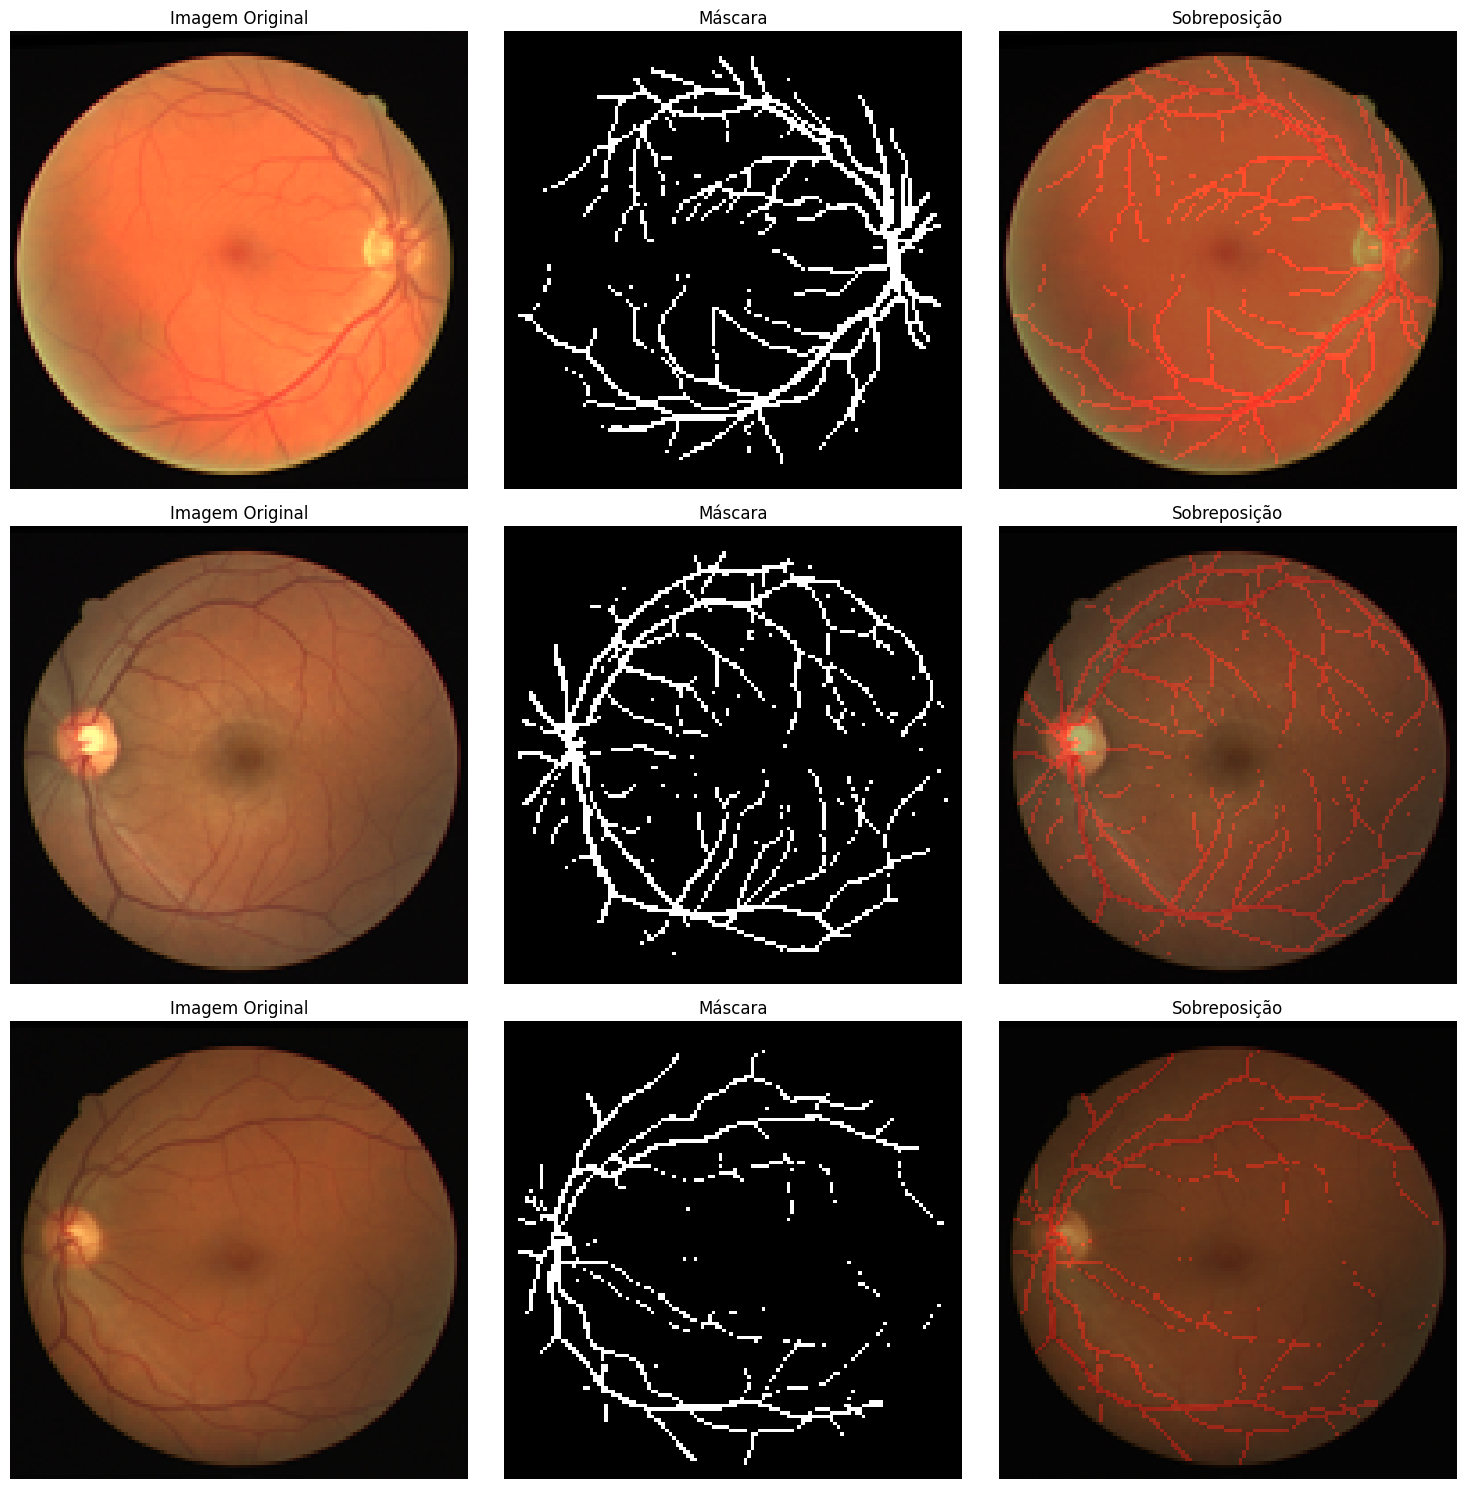

Pré-processamento concluído. Os datasets 'treino_dataset' e 'teste_dataset' estão prontos para uso no modelo.


In [ ]:
pasta_treinamento = os.path.join(path, "Data", "train")
pasta_teste = os.path.join(path, "Data", "test")

# Verificar se os caminhos existem
print(f"Verificando caminho do dataset: {path}")
print(f"O caminho existe? {os.path.exists(path)}")

print(f"Verificando pasta de treinamento: {pasta_treinamento}")
print(f"A pasta de treinamento existe? {os.path.exists(pasta_treinamento)}")

# Função de pré-processamento para carregar e redimensionar as imagens
def carregar_e_preprocessar_dados(pasta_imagem, pasta_mascara, tamanho_alvo=(128, 128)):

    # Verificar se as pastas existem
    if not os.path.exists(pasta_imagem):
        raise FileNotFoundError(f"Pasta de imagens não encontrada: {pasta_imagem}")
    if not os.path.exists(pasta_mascara):
        raise FileNotFoundError(f"Pasta de máscaras não encontrada: {pasta_mascara}")

    print(f"Carregando dados de: {pasta_imagem} e {pasta_mascara}")

    imagens = []
    mascaras = []

    # Listar os arquivos nas pastas
    arquivos_imagem = sorted([f for f in os.listdir(pasta_imagem)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    arquivos_mascara = sorted([f for f in os.listdir(pasta_mascara)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    print(f"Encontrados {len(arquivos_imagem)} imagens e {len(arquivos_mascara)} máscaras")

    # Processar cada par de imagem e máscara
    for arquivo_img, arquivo_mask in tqdm(zip(arquivos_imagem, arquivos_mascara), total=len(arquivos_imagem)):
        # Carregar imagem e redimensionar
        caminho_imagem = os.path.join(pasta_imagem, arquivo_img)
        img = Image.open(caminho_imagem)
        img = img.resize(tamanho_alvo)
        img_array = np.array(img)

        # Carregar máscara e redimensionar
        caminho_mascara = os.path.join(pasta_mascara, arquivo_mask)
        mask = Image.open(caminho_mascara)
        mask = mask.resize(tamanho_alvo)
        mask_array = np.array(mask)

        # Converter máscara para binário (0 ou 1)
        if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
            # Se a máscara tiver múltiplos canais, converter para escala de cinza
            mask_array = np.mean(mask_array, axis=2)

        # Binarizar a máscara (limiar em 128)
        mask_array = (mask_array > 128).astype(np.float32)

        # Adicionar dimensão de canal se necessário
        if len(mask_array.shape) == 2:
            mask_array = np.expand_dims(mask_array, axis=-1)

        # Normalizar imagem (dividir por 255 para escalar entre 0-1)
        img_array = img_array.astype(np.float32) / 255.0

        # Adicionar aos arrays
        imagens.append(img_array)
        mascaras.append(mask_array)

    return np.array(imagens), np.array(mascaras)

# Criar datasets do TensorFlow para treinamento e teste
def criar_tf_dataset(imagens, mascaras, tamanho_batch=32, shuffle=True):

    dataset = tf.data.Dataset.from_tensor_slices((imagens, mascaras))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(imagens))

    dataset = dataset.batch(tamanho_batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Tente encontrar automaticamente os caminhos corretos
def encontrar_pastas_dataset():
    base_path = '/content/drive/MyDrive'

    # Lugares possíveis para o dataset
    caminhos_possiveis = [
        os.path.join(base_path, 'dataset_retina'),
        os.path.join(base_path, 'Colab Notebooks', 'dataset_retina')
    ]

    # Verificar qual caminho existe
    for caminho in caminhos_possiveis:
        if os.path.exists(caminho):
            print(f"Dataset encontrado em: {caminho}")
            return caminho

    # Se não encontrar, tentar procurar em MyDrive
    print("Procurando pelo dataset em My Drive...")
    for root, dirs, files in os.walk(base_path):
        if 'dataset_retina' in dirs:
            caminho = os.path.join(root, 'dataset_retina')
            print(f"Dataset encontrado em: {caminho}")
            return caminho

    print("Dataset não encontrado!")
    return None

# Encontrar o caminho correto do dataset
path_encontrado = encontrar_pastas_dataset()
if path_encontrado:
    path = path_encontrado
    dataset_path = Path(path)
    pasta_treinamento = os.path.join(path, "Data", "train")
    pasta_teste = os.path.join(path, "Data", "test")

    # Verificar se as subpastas existem
    pasta_img_treino = os.path.join(pasta_treinamento, "image")
    pasta_mask_treino = os.path.join(pasta_treinamento, "mask")
    pasta_img_teste = os.path.join(pasta_teste, "image")
    pasta_mask_teste = os.path.join(pasta_teste, "mask")

    print("\nCaminhos encontrados:")
    print(f"Imagens de treino: {pasta_img_treino} (Existe: {os.path.exists(pasta_img_treino)})")
    print(f"Máscaras de treino: {pasta_mask_treino} (Existe: {os.path.exists(pasta_mask_treino)})")
    print(f"Imagens de teste: {pasta_img_teste} (Existe: {os.path.exists(pasta_img_teste)})")
    print(f"Máscaras de teste: {pasta_mask_teste} (Existe: {os.path.exists(pasta_mask_teste)})")

    # Carregar dados somente se os caminhos existirem
    if os.path.exists(pasta_img_treino) and os.path.exists(pasta_mask_treino):
        print("\nCarregando dados de treinamento...")
        X_treino, y_treino = carregar_e_preprocessar_dados(pasta_img_treino, pasta_mask_treino)
        print(f"Dados de treinamento carregados: {X_treino.shape}, {y_treino.shape}")

        # Criar dataset de treinamento
        treino_dataset = criar_tf_dataset(X_treino, y_treino)
        print("Dataset de treinamento criado com sucesso!")
    else:
        print("Erro: Pastas de imagens ou máscaras de treinamento não encontradas.")

    if os.path.exists(pasta_img_teste) and os.path.exists(pasta_mask_teste):
        print("\nCarregando dados de teste...")
        X_teste, y_teste = carregar_e_preprocessar_dados(pasta_img_teste, pasta_mask_teste)
        print(f"Dados de teste carregados: {X_teste.shape}, {y_teste.shape}")

        # Criar dataset de teste
        teste_dataset = criar_tf_dataset(X_teste, y_teste, shuffle=False)
        print("Dataset de teste criado com sucesso!")
    else:
        print("Erro: Pastas de imagens ou máscaras de teste não encontradas.")

    # Visualizar algumas imagens para verificar
    def visualizar_amostras(dataset, num_amostras=3):
        plt.figure(figsize=(15, 5*num_amostras))

        for i, (imagens, mascaras) in enumerate(dataset.take(num_amostras)):
            imagem = imagens[0].numpy()  # Pegar a primeira imagem do batch
            mascara = mascaras[0].numpy()  # Pegar a primeira máscara do batch

            # Imagem original
            plt.subplot(num_amostras, 3, i*3+1)
            plt.imshow(imagem)
            plt.title('Imagem Original')
            plt.axis('off')

            # Máscara
            plt.subplot(num_amostras, 3, i*3+2)
            plt.imshow(mascara[:,:,0], cmap='gray')
            plt.title('Máscara')
            plt.axis('off')

            # Sobreposição
            plt.subplot(num_amostras, 3, i*3+3)
            sobreposicao = imagem.copy()
            mascara_overlay = np.zeros_like(sobreposicao)
            mascara_overlay[:,:,0] = mascara[:,:,0] * 1.0  # Canal vermelho
            sobreposicao = sobreposicao * 0.7 + mascara_overlay * 0.3
            plt.imshow(sobreposicao)
            plt.title('Sobreposição')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualizar alguns exemplos, se o dataset foi criado
    if 'treino_dataset' in locals():
        print("\nVisualizando amostras para verificar o pré-processamento:")
        visualizar_amostras(treino_dataset)

        print("Pré-processamento concluído. Os datasets 'treino_dataset' e 'teste_dataset' estão prontos para uso no modelo.")

else:
    print("Não foi possível encontrar o dataset. Verifique manualmente o caminho correto.")

## TREINAMENTO DO MODELO

In [ ]:
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    """
    Gerador de dados que carrega imagens e máscaras, com opção de aumentação de dados.
    Compatível com a API de treinamento do Keras.
    """
    def __init__(self, img_dir, mask_dir, batch_size=8, img_size=(128, 128), shuffle=True, augment=True):
        """
        Inicializa o gerador de dados

        Parâmetros:
            img_dir: pasta onde estão as imagens
            mask_dir: pasta onde estão as máscaras
            batch_size: quantidade de imagens processadas em cada lote
            img_size: tamanho das imagens (altura, largura)
            shuffle: se deve embaralhar os dados a cada época
            augment: se deve aplicar técnicas de aumentação de dados
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment

        # Lista todos os arquivos de imagem e máscara
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

        # Verifica se o número de imagens e máscaras é igual
        assert len(self.img_files) == len(self.mask_files), "Número de imagens e máscaras não correspondem"

        # Cria índices para acesso aleatório
        self.indices = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Retorna o número de lotes por época"""
        return len(self.img_files) // self.batch_size

    def on_epoch_end(self):
        """Embaralha os índices após cada época se shuffle=True"""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        """
        Gera um lote de dados

        Parâmetros:
            index: índice do lote

        Retorna:
            Tupla contendo (imagens, máscaras) para o lote
        """
        # Seleciona índices para o lote atual
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Inicializa arrays vazios para o lote
        batch_imgs = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, *self.img_size, 1), dtype=np.float32)

        # Carrega cada imagem e máscara
        for i, idx in enumerate(batch_indices):
            # Carrega a imagem com tratamento de erros
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            try:
                # Tenta carregar com PIL primeiro (mais confiável para formatos variados)
                img = Image.open(img_path)
                img = img.resize(self.img_size)
                img_array = np.array(img)

                # Garantir que a imagem tenha 3 canais (RGB)
                if len(img_array.shape) == 2:  # Se for grayscale
                    img_array = np.stack([img_array, img_array, img_array], axis=2)
                elif img_array.shape[2] > 3:  # Se tiver canal alpha
                    img_array = img_array[:, :, :3]

                # Normalização
                img_array = img_array.astype(np.float32) / 255.0
            except Exception as e:
                # Fallback para OpenCV se PIL falhar
                print(f"PIL falhou ao carregar {img_path}, tentando com OpenCV. Erro: {e}")
                img = cv2.imread(img_path)
                if img is None:
                    raise ValueError(f"Não foi possível carregar a imagem: {img_path}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, self.img_size)
                img_array = img.astype(np.float32) / 255.0

            # Carrega a máscara com tratamento de erros
            mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
            try:
                # Tenta carregar com PIL primeiro
                mask = Image.open(mask_path)
                mask = mask.resize(self.img_size)
                mask_array = np.array(mask)
            except Exception as e:
                # Fallback para OpenCV
                print(f"PIL falhou ao carregar {mask_path}, tentando com OpenCV. Erro: {e}")
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    raise ValueError(f"Não foi possível carregar a máscara: {mask_path}")
                mask = cv2.resize(mask, self.img_size)
                mask_array = mask

            # Processa a máscara para formato binário
            if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
                # Se a máscara tiver múltiplos canais, converte para escala de cinza
                mask_array = np.mean(mask_array, axis=2)

            # Binarização: valor > 128 = 1, caso contrário = 0
            mask_array = (mask_array > 128).astype(np.float32)

            # Adiciona dimensão de canal se necessário
            if len(mask_array.shape) == 2:
                mask_array = np.expand_dims(mask_array, axis=-1)

            # Armazena no lote
            batch_imgs[i] = img_array
            batch_masks[i] = mask_array

        # Aplica aumentação de dados se habilitado
        if self.augment:
            batch_imgs, batch_masks = self._apply_augmentation(batch_imgs, batch_masks)

        return batch_imgs, batch_masks

    def _apply_augmentation(self, imgs, masks):
        """
        Aplica técnicas de aumentação aos lotes de imagens e máscaras

        Parâmetros:
            imgs: lote de imagens
            masks: lote de máscaras

        Retorna:
            Tupla com imagens e máscaras aumentadas
        """
        for i in range(len(imgs)):
            # Rotação aleatória (50% de chance)
            if np.random.rand() > 0.5:
                angle = np.random.randint(-20, 20)
                imgs[i] = rotate(imgs[i], angle, reshape=False, order=1, mode='nearest')
                masks[i] = rotate(masks[i], angle, reshape=False, order=0, mode='nearest')

            # Espelhamento horizontal (30% de chance)
            if np.random.rand() > 0.7:
                imgs[i] = np.fliplr(imgs[i])
                masks[i] = np.fliplr(masks[i])

            # Ajuste de brilho e contraste (40% de chance)
            if np.random.rand() > 0.6:
                brightness = np.random.uniform(0.8, 1.2)
                imgs[i] = np.clip(imgs[i] * brightness, 0, 1)

            # Zoom aleatório (20% de chance)
            if np.random.rand() > 0.8:
                zoom_factor = np.random.uniform(0.8, 1.2)
                h, w = imgs[i].shape[:2]

                # Aplica zoom às imagens
                zoom_tuple = (zoom_factor,) * 2 + (1,)  # Não aplica zoom no canal de cores
                imgs[i] = self._apply_zoom(imgs[i], zoom_tuple)

                # Aplica o mesmo zoom às máscaras
                mask_zoom = (zoom_factor,) * 2 + (1,)
                masks[i] = self._apply_zoom(masks[i], mask_zoom)

        return imgs, masks

    def _apply_zoom(self, image, zoom_tuple):
        """
        Aplica zoom em uma imagem mantendo suas dimensões originais

        Parâmetros:
            image: imagem a ser processada
            zoom_tuple: fator de zoom para cada dimensão

        Retorna:
            Imagem com zoom aplicado
        """
        h, w = image.shape[:2]

        # Aplica o zoom
        zoomed = zoom(image, zoom_tuple, mode='nearest')

        # Ajusta o tamanho para manter dimensões originais
        zh, zw = zoomed.shape[:2]

        # Se ampliou (zoom > 1), recorta o centro
        if zh > h and zw > w:
            start_h = (zh - h) // 2
            start_w = (zw - w) // 2
            zoomed = zoomed[start_h:start_h+h, start_w:start_w+w]

        # Se reduziu (zoom < 1), preenche as bordas
        elif zh < h or zw < w:
            # Cria uma nova imagem com as dimensões originais
            result = np.zeros_like(image)
            # Calcula onde posicionar a imagem com zoom
            start_h = (h - zh) // 2
            start_w = (w - zw) // 2
            # Insere a imagem com zoom no centro
            result[start_h:start_h+zh, start_w:start_w+zw] = zoomed
            zoomed = result

        return zoomed


# Criação dos geradores para treino e teste
def criar_geradores(pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste, batch_size=8):
    """
    Cria geradores para os conjuntos de treino e teste

    Parâmetros:
        pasta_img_treino: pasta das imagens de treino
        pasta_mask_treino: pasta das máscaras de treino
        pasta_img_teste: pasta das imagens de teste
        pasta_mask_teste: pasta das máscaras de teste
        batch_size: tamanho do lote

    Retorna:
        Dicionário com os geradores de treino e teste
    """
    # Gerador para o conjunto de treino (com aumentação de dados)
    train_generator = AugmentedDataGenerator(
        img_dir=pasta_img_treino,
        mask_dir=pasta_mask_treino,
        batch_size=batch_size,
        img_size=(128, 128),
        shuffle=True,
        augment=True  # Ativa aumentação para treino
    )

    # Gerador para o conjunto de teste (sem aumentação)
    test_generator = AugmentedDataGenerator(
        img_dir=pasta_img_teste,
        mask_dir=pasta_mask_teste,
        batch_size=batch_size,
        img_size=(128, 128),
        shuffle=False,
        augment=False   # Desativa aumentação para teste
    )

    # Retorna os geradores
    return {
        'treino': train_generator,
        'teste': test_generator
    }


# Exemplo de uso:
# Assumindo que as variáveis de pasta já estão definidas
geradores = criar_geradores(pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste, batch_size=8)

# Informação sobre os geradores
print(f"Conjunto de treinamento: {len(geradores['treino']) * geradores['treino'].batch_size} imagens")
print(f"Conjunto de teste: {len(geradores['teste']) * geradores['teste'].batch_size} imagens")

# Para usar com o modelo:
# model.fit(
#     geradores['treino'],
#     epochs=50,
#     validation_data=geradores['teste']
# )

Conjunto de treinamento: 80 imagens
Conjunto de teste: 16 imagens


In [ ]:
def mobile_encoder_block(inputs, filters, kernel_size=3, strides=1, use_batch_norm=True, dropout_rate=None):
    """Bloco encoder usando convoluções separáveis para eficiência"""
    # Depthwise separable convolution (mais eficiente que convoluções regulares)
    x = layers.SeparableConv2D(filters, kernel_size, padding='same', strides=strides)(inputs)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(alpha=0.1)(x)

    # Segunda convolução separável
    x = layers.SeparableConv2D(filters, kernel_size, padding='same')(x)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(alpha=0.1)(x)

    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

def refinement_module(inputs, skip_connection, filters):
    """Módulo de refinamento para melhorar a detecção de bordas"""
    # Reduz os canais do skip connection para alinhamento
    refined_skip = layers.Conv2D(filters//2, 1, padding='same')(skip_connection)
    refined_skip = layers.BatchNormalization()(refined_skip)
    refined_skip = layers.LeakyReLU(alpha=0.1)(refined_skip)

    # Extrai características de bordas usando filtros de diferentes tamanhos
    edge_detect1 = layers.SeparableConv2D(filters//4, 3, padding='same')(refined_skip)
    edge_detect2 = layers.SeparableConv2D(filters//4, 5, padding='same')(refined_skip)

    # Concatena as características de borda
    edge_features = layers.Concatenate()([edge_detect1, edge_detect2])

    # Combine com o input ascendente
    combined = layers.Concatenate()([inputs, edge_features])

    # Refina as características combinadas
    refined = layers.Conv2D(filters, 1, padding='same')(combined)
    refined = layers.BatchNormalization()(refined)
    refined = layers.LeakyReLU(alpha=0.1)(refined)

    return refined

def spatial_attention(inputs):
    """Mecanismo de atenção espacial para focar em áreas importantes"""
    # Operações de pooling para reduzir dimensionalidade
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(inputs)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(inputs)

    # Concatena os mapas de característica de pooling
    attention = layers.Concatenate()([avg_pool, max_pool])

    # Gera mapa de atenção usando convolução
    attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(attention)

    # Aplica o mapa de atenção aos inputs
    return layers.multiply([inputs, attention])

def unetmer_model(input_size=(128, 128, 3), num_classes=1):
    """UNetMER: UNet with Mobile Encoder and Refinement"""
    inputs = layers.Input(input_size)

    # Encoder (caminho de contração)
    enc1 = mobile_encoder_block(inputs, 64, dropout_rate=0.1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(enc1)

    enc2 = mobile_encoder_block(pool1, 128, dropout_rate=0.1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(enc2)

    enc3 = mobile_encoder_block(pool2, 256, dropout_rate=0.2)
    enc3 = spatial_attention(enc3)  # Aplicação de atenção espacial
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(enc3)

    enc4 = mobile_encoder_block(pool3, 512, dropout_rate=0.2)
    enc4 = spatial_attention(enc4)  # Aplicação de atenção espacial
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bridge
    bridge = mobile_encoder_block(pool4, 1024, dropout_rate=0.3)

    # Decoder (caminho de expansão) com módulos de refinamento
    # Nível 4
    up4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    dec4 = refinement_module(up4, enc4, 512)
    dec4 = mobile_encoder_block(dec4, 512, dropout_rate=0.2)

    # Nível 3
    up3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dec4)
    dec3 = refinement_module(up3, enc3, 256)
    dec3 = mobile_encoder_block(dec3, 256, dropout_rate=0.2)

    # Nível 2
    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dec3)
    dec2 = refinement_module(up2, enc2, 128)
    dec2 = mobile_encoder_block(dec2, 128, dropout_rate=0.1)

    # Nível 1
    up1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dec2)
    dec1 = refinement_module(up1, enc1, 64)
    dec1 = mobile_encoder_block(dec1, 64, dropout_rate=0.1)

    # Camada de saída
    output_layer = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(dec1)

    # Criação do modelo
    model = models.Model(inputs=inputs, outputs=output_layer)
    return model

def compile_unetmer(model, learning_rate=1e-4):
    """Compila o modelo UNetMER com otimizador e métricas apropriadas"""
    # Métricas personalizadas para segmentação
    def dice_coef(y_true, y_pred, smooth=1.0):
        # Converter explicitamente ambos os tensores para float32 para evitar incompatibilidade de tipos
        y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
        y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    def dice_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)

    def bce_dice_loss(y_true, y_pred):
        # Combinação de binary crossentropy e dice loss
        # Garantir que ambos os tensores estejam no mesmo tipo de dados para evitar erros
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    # Configuração do otimizador com learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compilação do modelo
    model.compile(
        optimizer=optimizer,
        loss=bce_dice_loss,
        metrics=[
            dice_coef,
            'binary_accuracy',
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision()
        ]
    )

    return model

def get_improved_callbacks(model_name='unetmer_retina'):
    """Callbacks para monitorar e otimizar o treinamento"""
    # Redução do learning rate se houver estagnação no treinamento
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping para evitar overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='binary_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Checkpoint para salvar o melhor modelo
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}_best.h5",
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # TensorBoard para visualização do treinamento
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f'./logs/{model_name}',
        histogram_freq=1
    )

    return [reduce_lr, early_stop, checkpoint, tensorboard]

# Instanciar o modelo UNetMER
unetmer = unetmer_model(input_size=(128, 128, 3), num_classes=1)
unetmer = compile_unetmer(unetmer)
# Exibir o resumo do modelo
unetmer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_26       │ (None, 128, 128, 64)   │            283 │ input_layer_1[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 64)   │            256 │ separable_conv2d_26[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_27       │ (None, 128, 128, 64)   │          4,736 │ leaky_re_lu_26[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 128, 128, 64)   │            256 │ separable_conv2d_27[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_27            │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ dropout_9[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_28       │ (None, 64, 64, 128)    │          8,896 │ max_pooling2d_4[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 64, 64, 128)    │            512 │ separable_conv2d_28[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_28            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_29       │ (None, 64, 64, 128)    │         17,664 │ leaky_re_lu_28[0][0]   │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 6,456,674 (24.63 MB)

 Trainable params: 6,442,018 (24.57 MB)

 Non-trainable params: 14,656 (57.25 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - binary_accuracy: 0.5980 - dice_coef: 0.1277 - loss: 1.4822 - precision_1: 0.1798 - recall_1: 0.2958 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.1274 - val_loss: 1.5618 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - binary_accuracy: 0.5798 - dice_coef: 0.1344 - loss: 1.4329 - precision_1: 0.2985 - recall_1: 0.2736 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.1273 - val_loss: 1.5575 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - binary_accuracy: 0.6705 - dice_coef: 0.1425 - loss: 1.3949 - precision_1: 0.2109 - recall_1: 0.2918 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.1272 - val_loss: 1.5534 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - binary_accuracy: 0.6846 - dice_coef: 0.1475 - loss: 1.3590 - precision_1: 0.2284 - recall_1: 0.2162 - val

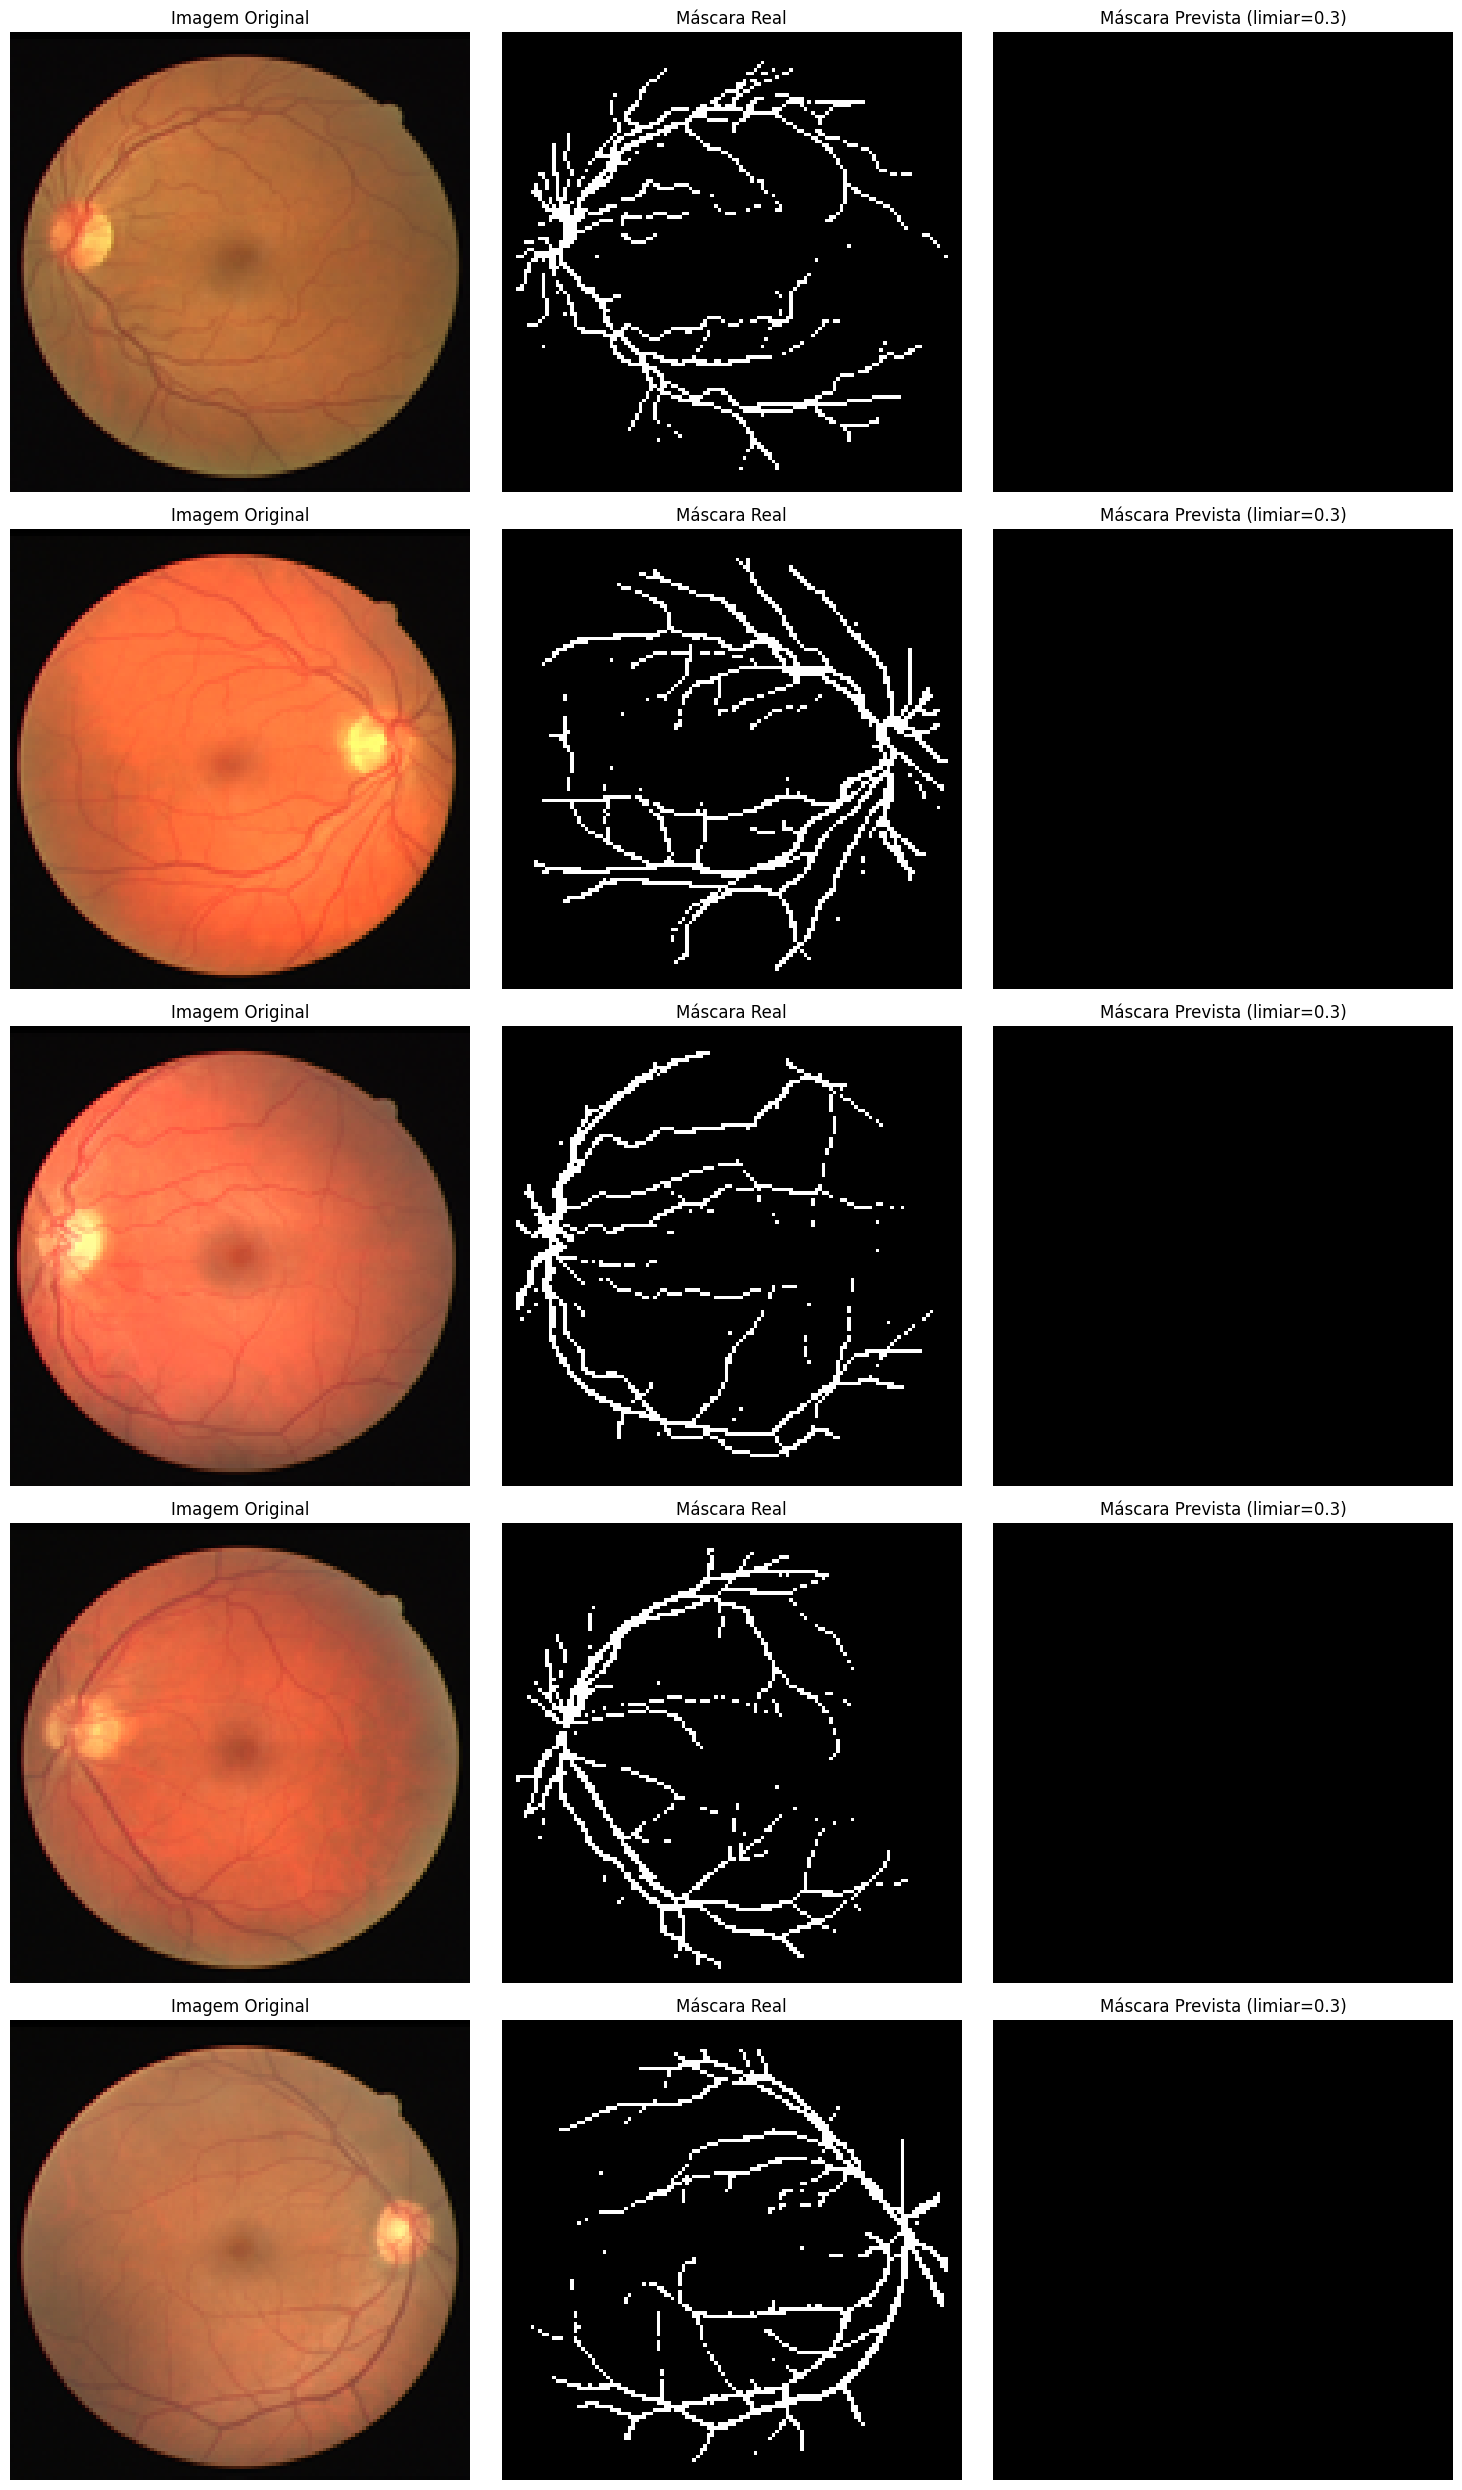

<Figure size 800x600 with 0 Axes>

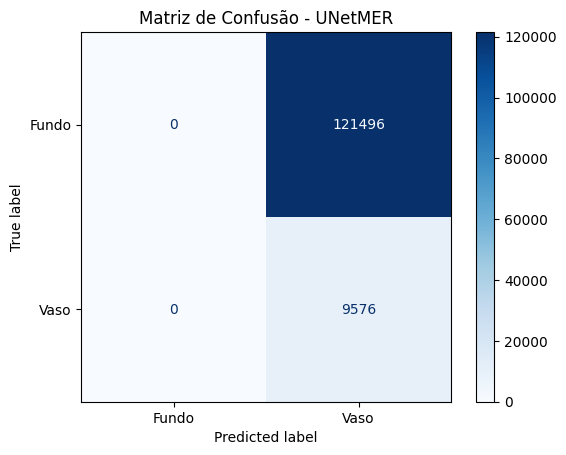


Métricas de avaliação detalhadas:
Acurácia: 0.0731
Precisão: 0.0731
Recall: 1.0000
F1-Score: 0.1362
Métricas disponíveis no histórico: ['binary_accuracy', 'dice_coef', 'loss', 'precision_1', 'recall_1', 'val_binary_accuracy', 'val_dice_coef', 'val_loss', 'val_precision_1', 'val_recall_1']
Métricas mapeadas: {'loss': 'loss', 'dice_coef': 'dice_coef', 'binary_accuracy': 'binary_accuracy', 'recall': 'recall_1', 'precision': 'precision_1'}


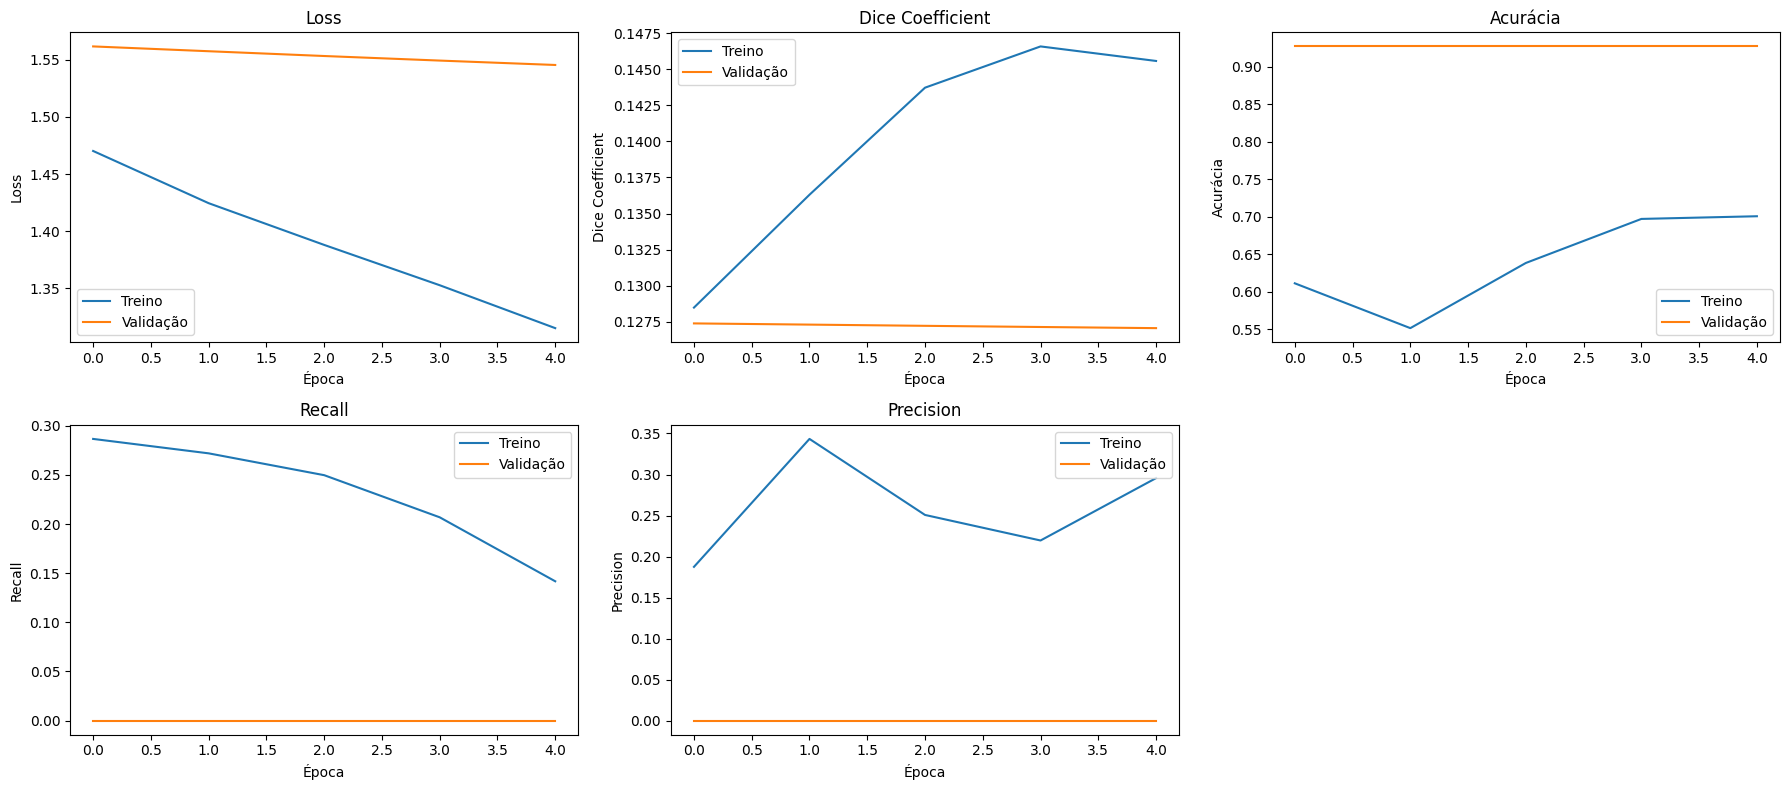

In [ ]:
#Treinar o modelo UNetMER
history_unetmer = unetmer.fit(
     geradores['treino'],
     epochs=5,
     validation_data=geradores['teste']
)



def evaluate_unetmer(model, test_generator, num_samples=5):
    """
    Avalia e visualiza os resultados do modelo UNetMER

    Args:
        model: Modelo treinado
        test_generator: Gerador de dados de teste
        num_samples: Número de amostras a visualizar
    """
    # Avaliar o modelo no conjunto de teste
    test_results = model.evaluate(test_generator, verbose=1)
    print("\nResultados da avaliação do UNetMER:")
    for i, metric in enumerate(model.metrics_names):
        print(f"{metric}: {test_results[i]:.4f}")

    # Obter um batch de dados
    x_batch, y_batch = next(iter(test_generator))

    # Fazer previsões com o modelo - aplicar sigmoid nas previsões
    predictions = tf.keras.activations.sigmoid(model.predict(x_batch))

    # Binarizar as previsões para visualização usando um limiar menor
    limiar = 0.3  # Ajuste desse valor pode melhorar a visualização dos vasos finos
    predictions_binary = (predictions.numpy() > limiar).astype(np.float32)

    # Visualizar algumas previsões
    fig, axes = plt.subplots(min(num_samples, len(x_batch)), 3, figsize=(15, 5*min(num_samples, len(x_batch))))

    for i in range(min(num_samples, len(x_batch))):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara prevista (binarizada)
        axes[i, 2].imshow(predictions_binary[i, :, :, 0], cmap='gray')
        axes[i, 2].set_title(f'Máscara Prevista (limiar={limiar})')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Calcular e visualizar a matriz de confusão
    y_true = (y_batch.reshape(-1) > 0.5).astype(int)
    y_pred = (predictions.numpy().reshape(-1) > limiar).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fundo', 'Vaso'])
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusão - UNetMER')
    plt.show()

    # Calcular métricas específicas para avaliação de segmentação de vasos
    print("\nMétricas de avaliação detalhadas:")
    precision_val = cm[1,1] / (cm[1,1] + cm[0,1] + 1e-7)  # Precision para classe positiva (vasos)
    recall_val = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-7)     # Recall para classe positiva (vasos)
    f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-7)
    accuracy_val = (cm[0,0] + cm[1,1]) / np.sum(cm)

    print(f"Acurácia: {accuracy_val:.4f}")
    print(f"Precisão: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_score_val:.4f}")

# Plotar histórico de treinamento (versão corrigida)
def plot_unetmer_training_history(history):
    # Primeiro, vamos verificar quais métricas estão disponíveis no histórico
    print("Métricas disponíveis no histórico:", list(history.history.keys()))

    # Definir mapeamentos para métricas possíveis (nomes comuns no Keras)
    metric_mappings = {
        'loss': 'loss',
        'dice_coef': 'dice_coef',  # Nossa métrica personalizada
        'binary_accuracy': ['binary_accuracy', 'accuracy'],  # Possíveis nomes para acurácia
        'recall': ['recall', 'recall_1', 'recall_2'],  # Possíveis nomes para recall
        'precision': ['precision', 'precision_1', 'precision_2']  # Possíveis nomes para precisão
    }

    # Encontrar os nomes reais no histórico
    available_metrics = {}
    for key, possible_names in metric_mappings.items():
        if isinstance(possible_names, list):
            for name in possible_names:
                if name in history.history:
                    available_metrics[key] = name
                    break
        else:
            if possible_names in history.history:
                available_metrics[key] = possible_names

    # Exibir as métricas disponíveis encontradas
    print("Métricas mapeadas:", available_metrics)

    # Definir métricas e títulos para plotar (apenas as disponíveis)
    metrics_to_plot = []
    titles_to_plot = []

    if 'loss' in available_metrics:
        metrics_to_plot.append(available_metrics['loss'])
        titles_to_plot.append('Loss')

    if 'dice_coef' in available_metrics:
        metrics_to_plot.append(available_metrics['dice_coef'])
        titles_to_plot.append('Dice Coefficient')

    if 'binary_accuracy' in available_metrics:
        metrics_to_plot.append(available_metrics['binary_accuracy'])
        titles_to_plot.append('Acurácia')

    if 'recall' in available_metrics:
        metrics_to_plot.append(available_metrics['recall'])
        titles_to_plot.append('Recall')

    if 'precision' in available_metrics:
        metrics_to_plot.append(available_metrics['precision'])
        titles_to_plot.append('Precision')

    # Criar subplots dinâmicos baseados no número de métricas disponíveis
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0:
        print("Nenhuma métrica válida encontrada no histórico.")
        return

    # Calcular layout ideal para os subplots
    cols = min(3, n_metrics)
    rows = (n_metrics + cols - 1) // cols  # Arredondar para cima: (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if n_metrics == 1:  # Caso especial para apenas uma métrica
        axes = np.array([axes])
    axes = axes.flatten()

    # Plotar cada métrica
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles_to_plot)):
        if i < len(axes):
            axes[i].plot(history.history[metric], label=f'Treino')
            val_metric = f'val_{metric}'
            if val_metric in history.history:
                axes[i].plot(history.history[val_metric], label=f'Validação')
            axes[i].set_title(title)
            axes[i].set_xlabel('Época')
            axes[i].set_ylabel(title)
            axes[i].legend()

    # Desativar eixos extras não utilizados
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Avaliar o modelo após o treinamento
print("\nAvaliando o modelo UNetMER...")
evaluate_unetmer(unetmer, geradores['teste'])

# Plotar o histórico de treinamento com a função corrigida
plot_unetmer_training_history(history_unetmer)

In [ ]:
model = unetmer

In [ ]:
def evaluate_unetmer(model, test_generator, num_samples=5):
    # Avaliar o modelo no conjunto de teste
    test_results = model.evaluate(test_generator, verbose=1)
    print("\nResultados da avaliação do UNetMER:")
    for i, metric in enumerate(model.metrics_names):
        print(f"{metric}: {test_results[i]:.4f}")

    # Visualizar algumas previsões
    x_batch, y_batch = next(iter(test_generator))
    predictions = model.predict(x_batch)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(predictions[i, :, :, 0], cmap='gray')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


evaluate_unetmer(model, test_generator)

NameError: name 'test_generator' is not defined

In [ ]:
def plot_training_history(history):
    """
    Plota gráficos de acurácia e loss do histórico de treinamento

    Parâmetros:
    - history: Objeto retornado por model.fit()
    """
    # Obtendo as métricas do histórico
    acc = history.history['binary_accuracy']  # No seu caso é binary_accuracy, não 'Accuracy'
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Treinamento')
    plt.plot(epochs, val_acc, 'r-', label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Treinamento')
    plt.plot(epochs, val_loss, 'r-', label='Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar métricas adicionais (como IoU)
    if 'iou' in history.history:
        plt.figure(figsize=(7, 5))
        plt.plot(epochs, history.history['iou'], 'b-', label='Treinamento')
        plt.plot(epochs, history.history['val_iou'], 'r-', label='Validação')
        plt.title('IoU por Época')
        plt.xlabel('Época')
        plt.ylabel('IoU')
        plt.legend()
        plt.show()

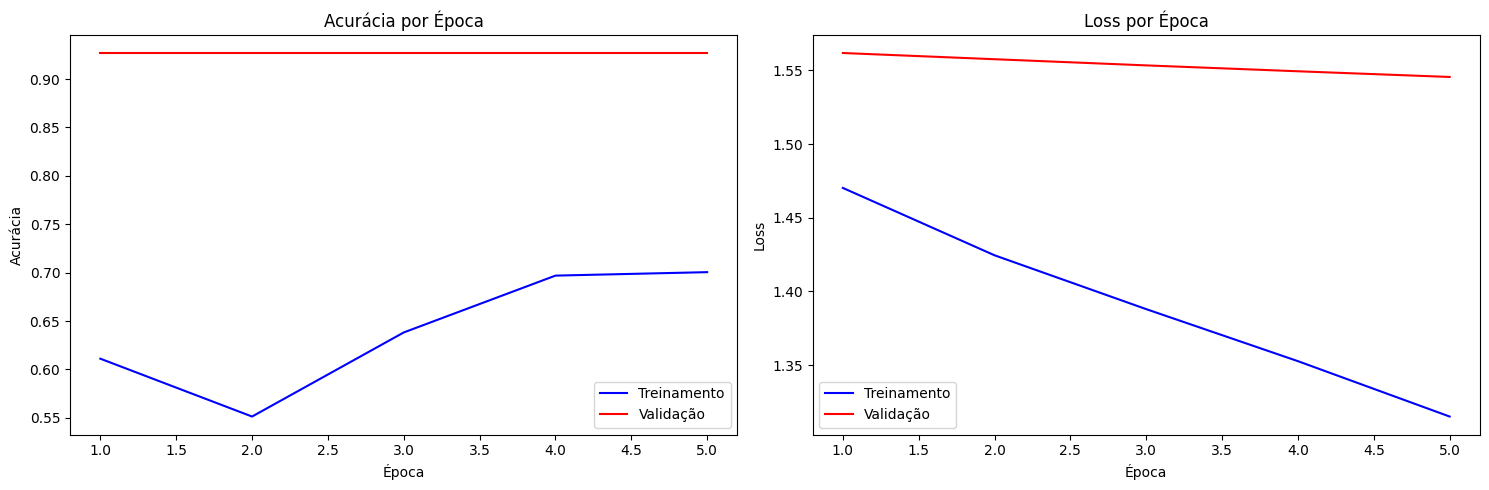

In [ ]:
plot_training_history(history_unetmer)